Scanning directory: /workspace/obsidian
Found 23540 files. Processing in parallel...
Loaded 23540 notes. Vectorizing...
Clustering into 8 groups...
Running dimensionality reduction...

--- Top Bi-gram Identifiers per Cluster ---
Cluster 0: justin hitt, date version, v0 justin, version contact, contact comment, 2018 v0, jwh consolidated, martinsville va
Cluster 1: lead generation, content marketing, keyword research, research topical, topical mapping, marketing content, mapping keyword, marketing lead
Cluster 2: pasted image, internet pasted, png screenshot, facebook reply, grid cabin, permalink facebook, make sure, timber frame
Cluster 3: note taking, artificial intelligence, knowledge management, information management, writing tools, management note, intelligence artificial, second brain
Cluster 4: strategic relations, justin hitt, profitable customers, business relationships, sincerely justin, sales marketing, global hotline, business business
Cluster 5: social media, risk managemen

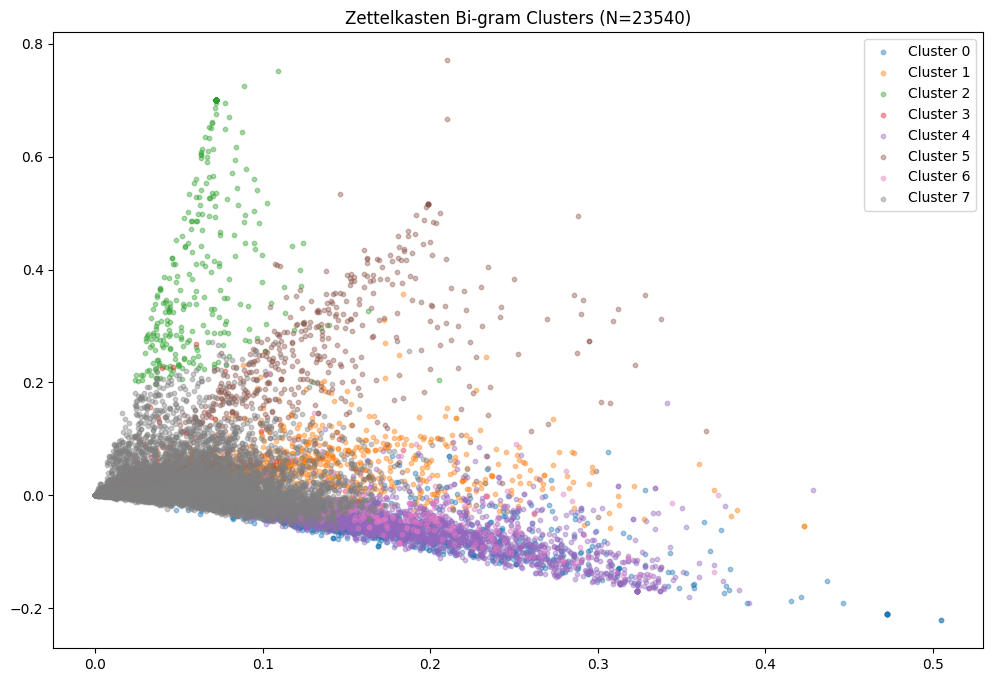

In [8]:
import os
import re
import sys
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

# --- Configuration ---
ZETTEL_ROOT = "/workspace/obsidian" # K8S Path
N_CLUSTERS = 8  # Increased for 32k files
TAG_WEIGHT = 5 

def split_camel_case(text):
    """Splits #CamelCase into 'Camel Case'."""
    return re.sub(r'([a-z])([A-Z])', r'\1 \2', text)

def is_date_pattern(text):
    """Check if text is a date pattern like YYYY-MM-DD or YYYYMMDD."""
    text_str = str(text).strip()
    return bool(re.match(r'^\d{4}(-\d{2}(-\d{2})?)?$|^\d{8}', text_str))

def clean_headers(text):
    """
    Keeps Markdown headers with more than 2 words.
    Returns the header content stripped of '#' for better n-gram tokenization.
    """
    lines = text.split('\n')
    filtered_lines = []
    for line in lines:
        if line.lstrip().startswith('#'):
            # Remove '#' and surrounding whitespace
            header_content = re.sub(r'^#+\s*', '', line).strip()
            words = header_content.split()
            # ONLY keep if more than 2 words
            if len(words) > 2:
                filtered_lines.append(header_content)
        else:
            filtered_lines.append(line)
    return '\n'.join(filtered_lines)

def extract_note_data(filepath):
    """CPU-bound task for parallel processing."""
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            content = f.read()
    except Exception as e:
        return None

    # 1. YAML Tags
    yaml_tags = []
    yaml_match = re.search(r'^---\s*\n(.*?)\n---\s*\n', content, re.DOTALL)
    if yaml_match:
        try:
            meta = yaml.safe_load(yaml_match.group(1))
            if meta and 'tags' in meta:
                raw_tags = meta['tags']
                if isinstance(raw_tags, list):
                    yaml_tags = [str(t) for t in raw_tags if t is not None and not is_date_pattern(t)]
                elif raw_tags is not None and not is_date_pattern(raw_tags):
                    yaml_tags = [str(raw_tags)]
        except:
            pass

    # 2. Hashtags
    hashtag_raw = re.findall(r'#([A-Z][a-z]+(?:[A-Z][a-z]+)+)', content)
    hashtag_split = [split_camel_case(ht) for ht in hashtag_raw if not is_date_pattern(ht)]
    
    # 3. Body Processing
    # Strip front matter
    body = re.sub(r'^---\s*\n(.*?)\n---\s*\n', '', content, flags=re.DOTALL)
    # Process headers (Keep > 2 words)
    body = clean_headers(body)
    # Remove dates
    body = re.sub(r'\d{4}-\d{2}-\d{2}|\d{4}-\d{2}|\d{8}', '', body)
    
    meta_str = (" ".join(yaml_tags) + " " + " ".join(hashtag_split) + " ") * TAG_WEIGHT
    feature_text = meta_str + body
    
    return {'name': filepath.name, 'text': feature_text.strip()}

def main():
    # --- Data Loading (Parallel) ---
    print(f"Scanning directory: {ZETTEL_ROOT}")
    files = list(Path(ZETTEL_ROOT).rglob('*.[mM][dD]'))
    print(f"Found {len(files)} files. Processing in parallel...")

    # Using ProcessPoolExecutor to bypass GIL for regex/parsing
    cpu_count = multiprocessing.cpu_count()
    with ProcessPoolExecutor(max_workers=cpu_count) as executor:
        results = list(executor.map(extract_note_data, files))

    data = [r for r in results if r is not None]
    df = pd.DataFrame(data)
    
    if df.empty:
        print("No valid data extracted. Exiting.")
        return

    print(f"Loaded {len(df)} notes. Vectorizing...")

    # --- Vectorization ---
    custom_stops = {'https', 'http', 'com', 'www', 'org', 'net', 'html', 'eof', 'g_face', 'q_auto'}
    all_stop_words = list(ENGLISH_STOP_WORDS.union(custom_stops))

    vectorizer = TfidfVectorizer(
        stop_words=all_stop_words,
        ngram_range=(2, 2), 
        max_features=5000, # Increased for 32k files
        min_df=5           # Ignore bi-grams appearing in fewer than 5 notes
    )

    X = vectorizer.fit_transform(df['text'])

    # --- Clustering ---
    print(f"Clustering into {N_CLUSTERS} groups...")
    model = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
    df['cluster'] = model.fit_predict(X)

    # --- Dimensionality Reduction (Memory Efficient) ---
    # TruncatedSVD works on sparse matrices; PCA requires dense arrays which will OOM.
    print("Running dimensionality reduction...")
    svd = TruncatedSVD(n_components=2, random_state=42)
    coords = svd.fit_transform(X)
    df['x'], df['y'] = coords[:, 0], coords[:, 1]

    # --- Identification ---
    print("\n--- Top Bi-gram Identifiers per Cluster ---")
    terms = vectorizer.get_feature_names_out()
    centroids = model.cluster_centers_.argsort()[:, ::-1]

    for i in range(N_CLUSTERS):
        top_terms = [terms[ind] for ind in centroids[i, :8]]
        print(f"Cluster {i}: {', '.join(top_terms)}")

    # --- Visualization ---
    plt.figure(figsize=(12, 8))
    for i in range(N_CLUSTERS):
        slice_df = df[df['cluster'] == i]
        plt.scatter(slice_df['x'], slice_df['y'], label=f"Cluster {i}", alpha=0.4, s=10)

    plt.title(f"Zettelkasten Bi-gram Clusters (N={len(df)})")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()
